# load data and do elementary calculations and plots

---

In [17]:
import os
import numpy as np
import dask
from dask_jobqueue import PBSCluster
import xarray as xr
from dask import compute, delayed
from matplotlib import pyplot as plt
%matplotlib inline

from mitequinox.utils import *



In [2]:
# launch cluster and workers

# folder where data is spilled when RAM is filled up
#local_dir = os.getenv('HOME')+'/dask_scratch/'
#local_dir = os.getenv('SCRATCH')+'/dask_scratch/'
#local_dir = os.getenv('DATAWORK')+'/dask_scratch/'
local_dir = os.getenv('TMPDIR')
#
cluster = PBSCluster(queue='mpi_1', local_directory=local_dir, interface='ib0', walltime='24:00:00',
                     threads=14, processes=2, memory='50GB', resource_spec='select=1:ncpus=28:mem=100g', 
                     death_timeout=100)


In [3]:
cluster.start_workers(40)

[2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41]

In [8]:
# you need to wait for workers to spin up
cluster.scheduler

<Scheduler: "tcp://10.148.1.108:49749" processes: 72 cores: 1008>

In [9]:
### get dask handles and check dask server status
from dask.distributed import Client
client = Client(cluster)

In [10]:
client

Client Scheduler: tcp://10.148.1.108:49749 Dashboard: http://10.148.1.108:8787/status,Cluster Workers: 72 Cores: 1008 Memory: 3600.00 GB


In [11]:

data_dir = '/home/datawork-lops-osi/data/mit4320/Eta/'
grid_dir = '/home/datawork-lops-osi/data/mit4320/grid/'

iters, time = get_iters_time('Eta', data_dir, delta_t=25.)

ds = get_compressed_data('Eta', data_dir, grid_dir, iters='all', time=time, client=client)
#ds = ds.chunk({'face': 1})
print(ds)
print('\n data size: %.1f GB' %(ds.nbytes / 1e9))


/home1/datahome/xyu/miniconda3/envs/equinox/lib/python3.6/site-packages/xmitgcm/mds_store.py:721: UserWarning: Couldn't find available_diagnostics.log in . Using default version.
  "in %s. Using default version." % data_dir)
/home1/datahome/xyu/miniconda3/envs/equinox/lib/python3.6/site-packages/xmitgcm/utils.py:314: UserWarning: Not sure what to do with rlev = L
  warnings.warn("Not sure what to do with rlev = " + rlev)
/home1/datahome/xyu/miniconda3/envs/equinox/lib/python3.6/site-packages/xmitgcm/mds_store.py:235: FutureWarning: iteration over an xarray.Dataset will change in xarray v0.11 to only include data variables, not coordinates. Iterate over the Dataset.variables property instead to preserve existing behavior in a forwards compatible manner.
  for vname in ds:


<xarray.Dataset>
Dimensions:  (face: 13, i: 4320, i_g: 4320, j: 4320, j_g: 4320, k: 90, k_l: 90, k_p1: 91, k_u: 90, time: 4096)
Coordinates:
  * i        (i) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
  * i_g      (i_g) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
  * j        (j) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
  * j_g      (j_g) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
  * k        (k) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
  * k_u      (k_u) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
  * k_l      (k_l) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
  * k_p1     (k_p1) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
  * face     (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
    XC       (face, j, i) >f4 dask.array<shape=(13, 4320, 4320), chunksize=(1, 4320, 4320)>
    YC       (face, j, i) >f4 dask.array<shape=(13, 4320, 4320), chunksize=(

---

# make movie

$\delta_x$

*italic*

- item 
- item
- item


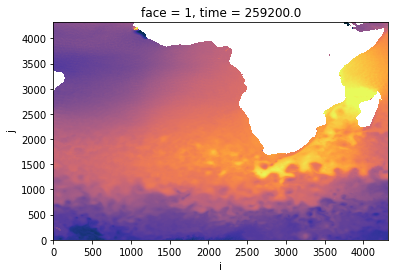

In [16]:
import cartopy.crs as ccrs
from cmocean import cm
#import matplotlib.pyplot as plt


face = 1
eta = ds['Eta'].isel(face=face, time=0)

vmin = -2.
vmax = 2.
#im = eta.plot.pcolormesh(transform=ccrs.PlateCarree(), vmin=vmin, vmax=vmax,
#                         x='XC', y='YC', add_colorbar=False, cmap=cm.thermal)
im = eta.plot.pcolormesh(vmin=vmin, vmax=vmax, add_colorbar=False, cmap=cm.thermal)

In [19]:
face = 1
vmin = -2.
vmax = 2.

figdir = os.getenv('DATAWORK')+'/mit/figs/'

def process(lds, i, overwrite=True):
    eta = lds['Eta']
    #
    #time = pd.to_datetime(str(eta['time'].values))
    time = eta['time'].values/86400.
    figname = figdir+'mit_eta_f%d_t%05d' %(face, i)+'.png'
    #
    if not os.path.isfile(figname) or overwrite:
        #
        title = 'eta %.2f' %time
        plot_eta(eta, colorbar=False, title=title, savefig=figname, vmin=vmin, vmax=vmax, 
                 offline=True, coast_resolution='50m', figsize=(15,10))
        #
        m = float(eta.mean().values)
    else:
        m = -1.
    return m

I = range(len(ds['time']))
I = range(100)
values = [delayed(process)(ds.isel(face=face, time=i), i) for i in I]



In [20]:
%time results = compute(*values, get=client.get)

KilledWorker: ('finalize-6d705b4ea4d0d67469bc6ec9651fb4e2', 'tcp://10.148.1.6:44981')

In [ ]:
plt.plot(results)

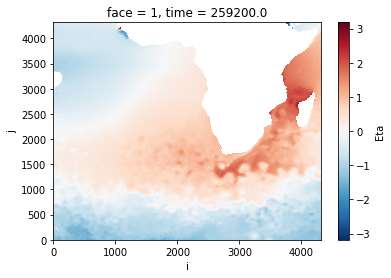

In [21]:
ds['Eta'].isel(face=1, time=0).plot()

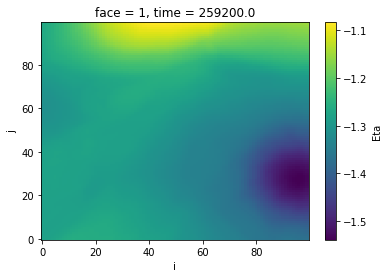

In [22]:
ds['Eta'].isel(face=1, time=0, i=slice(0,100), j=slice(0,100)).plot()

In [23]:
ds['Eta'].isel(face=1, i=0, j=0).mean().compute()

<xarray.DataArray 'Eta' ()>
array(-1.006087, dtype=float32)
Coordinates:
    i        int64 0
    j        int64 0
    face     int64 1
    XC       float32 -37.989582
    YC       float32 -57.001026
    rA       float32 1552802.6
    Depth    float32 3047.2024

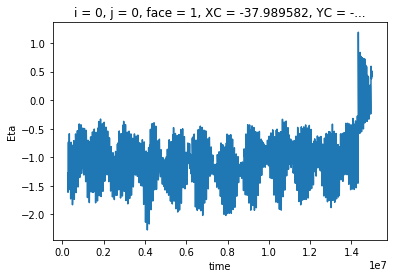

In [25]:
#ds['Eta'].isel(face=1, i=0, j=0, time=slice(0,2000)).plot()
ds['Eta'].isel(face=1, i=0, j=0).plot()
#.chunk({'time': 4096})

Notice the large increase in sea level at the end of the time series.
What is going ? do know about this?


CPU times: user 1min 8s, sys: 2.03 s, total: 1min 10s
Wall time: 2min 36s


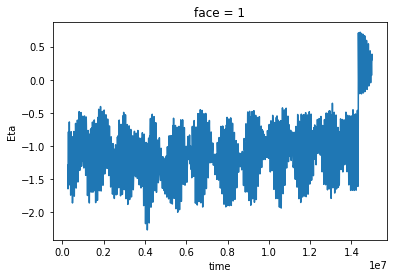

In [26]:
%time ds['Eta'].isel(face=1, i=slice(0,100), j=slice(0,100)).mean(dim=['i','j']).plot()

---

# basic statistics

In [27]:
%time m1 = ds['Eta'].isel(face=1).mean(['time']).persist()

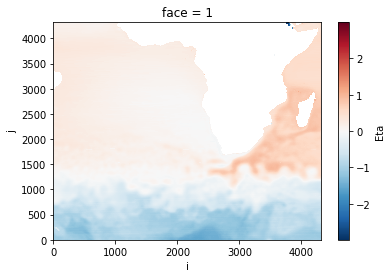

In [28]:
m1.plot()

---

# info, shutdown

In [17]:
client

Client Scheduler: tcp://10.148.1.110:39830 Dashboard: http://10.148.1.110:8787/status,Cluster Workers: 72 Cores: 1008 Memory: 3600.00 GB


In [ ]:
client.restart()

In [18]:
client.close()
cluster.stop_workers(cluster.jobs)

In [18]:
%load_ext autoreload
%autoreload 2